## Using Versatile Behavior Diffusion (VBD) with GPUDrive

---

> [VBD project page](https://sites.google.com/view/versatile-behavior-diffusion?pli=1) | [ArXiv](https://arxiv.org/abs/2404.02524)

---

In this notebook we demonstrate how you can generate realistic vehicle trajectories with VBD.

In [1]:
# Dependencies
import os
from pathlib import Path
import torch
import warnings
import mediapy
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from pygpudrive.env.env_torch import GPUDriveTorchEnv

# Plotting
sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (8, 3)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")

In [2]:
"""Helper functions for sanity checks (will be removed)."""

def plot_batch_distributions(batch, dist_type='hist'):

    num_keys = len(batch.keys())
    num_cols = 3
    num_rows = math.ceil(num_keys / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    fig.suptitle("Distribution of each batch -> f(batch) -> pred", y=1.02)
    axes = axes.flatten()

    for i, key in enumerate(batch.keys()):
        data = batch[key].cpu().numpy().flatten()
        
        if dist_type == 'hist':
            axes[i].hist(batch[key].cpu().numpy().flatten(), bins=30)
        elif dist_type == 'box_plot':
            
            sns.boxplot(data=data, ax=axes[i], width=0.3)
            # Add a strip plot to visualize individual data points
            sns.stripplot(data=data, ax=axes[i], color='k', size=3, jitter=True)
        
        max_value = data.max()
        min_value = data.min()
        axes[i].set_title(f"{key}: Min={min_value:.2f}, Max={max_value:.2f}")
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

## Configuration

 - We only control valid agents up to a maximum of 32
- The initialization steps: 10
- We use the `StateDynamics` model
    - this model has a 5D action `(x, y, yaw, velocity x, velocity y)`

In [3]:
INIT_STEPS = 10
NUM_ENVS = 1

scene_config = SceneConfig(
    path="data/interactive", 
    num_scenes=NUM_ENVS,
    discipline=SelectionDiscipline.K_UNIQUE_N,
    k_unique_scenes=1,
)

env_config = EnvConfig(
    init_steps=INIT_STEPS, # Warmup period
    enable_vbd=True, # Use VBD
    dynamics_model="state", # Use state-based dynamics model
)

render_config = RenderConfig(
    draw_obj_idx=True,
    render_init=True,
)

## Make environment


In [4]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    render_config=render_config,
    max_cont_agents=32, # Maximum number of agents to control per scene
    device="cpu",
    action_type="continuous",
)


--- Ratio unique scenes / number of worls =         1 / 1 ---



In [5]:
# Sanity check: We have a warmup period of 10 steps, so the first step should be 11
env.reset();
env.step_in_episode

selected_agents = torch.nonzero(env.cont_agent_mask[0, :]).flatten().tolist()

print(f"Selected agents: {selected_agents}")

2024-09-27 12:53:16.988354: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 12:53:17.008656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 12:53:17.441280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Selected agents: [6, 7, 8, 18, 19]


### Sanity check: Show the initialization logs

In [6]:
len(env.init_frames)

10

In [7]:
mediapy.show_video(images=env.init_frames, title=f'First {INIT_STEPS} steps, initialization with logged trajectories', width=500, loop=False)

Scenario at t = 10

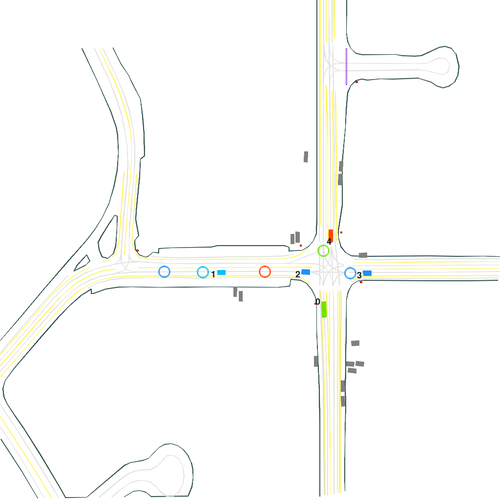

In [8]:
mediapy.show_image(image=env.render(), title=f"Scenario at t = {env.step_in_episode}", width=500)

## Load trained VBD model

In [9]:
# Load model
from vbd.sim_agent.sim_actor import VBDTest

ckpt_path = 'vbd/weights/epoch=18.ckpt'

model = VBDTest.load_from_checkpoint(ckpt_path, map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()

Uncomment to check all input distributions

In [10]:
#plot_batch_distributions(sample_batch, dist_type='box_plot')

## Rollout without goal guidance

In [11]:
# Get batch of data for VBD model
sample_batch = env.warmup_trajectory

In [12]:
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Reset the environment
init_state = env.reset()

current_state = init_state

# Obtain all info for diffusion model (warmup)
sample_batch = env.warmup_trajectory

# Make a prediction
pred = model.sample_denoiser(sample_batch)#, x_t=x_t)
vbd_traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

is_controlled = sample_batch['agents_interested'] > 0

# TODO: Hacky but needs to be done because our sim expects a 10 D action
log_playback_traj = env.get_expert_actions()
pred_trajs = log_playback_traj[:, :, INIT_STEPS+1:, :].clone().squeeze(0)
pred_trajs[:, :, 0:2] = torch.Tensor(vbd_traj_pred[:, :, 0:2]) # pos x, y
pred_trajs[:, :, 3] = torch.Tensor(vbd_traj_pred[:, :, 2]) # yaw x, y
pred_trajs[:, :, 4:6] = torch.Tensor(vbd_traj_pred[:, :, 3:5]) # vel x, y
pred_trajs = pred_trajs.unsqueeze(0)

# Step with diffussion trajectories
frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

print(f'Rolling out from {env.step_in_episode} to {env_config.episode_len} steps')

for t in range(env_config.episode_len-(INIT_STEPS+1)):
    
    print(f"Step {t+INIT_STEPS+1}/{env_config.episode_len}")

    env.step_dynamics(pred_trajs[:, :, t, :])

    for i in range(NUM_ENVS):
        frames[f"env_{i}"].append(env.render(i))

Diffusion: 100%|██████████| 50/50 [00:01<00:00, 35.58it/s]


Rolling out from 10 to 91 steps
Step 11/91
Step 12/91
Step 13/91
Step 14/91
Step 15/91
Step 16/91
Step 17/91
Step 18/91
Step 19/91
Step 20/91
Step 21/91
Step 22/91
Step 23/91
Step 24/91
Step 25/91
Step 26/91
Step 27/91
Step 28/91
Step 29/91
Step 30/91
Step 31/91
Step 32/91
Step 33/91
Step 34/91
Step 35/91
Step 36/91
Step 37/91
Step 38/91
Step 39/91
Step 40/91
Step 41/91
Step 42/91
Step 43/91
Step 44/91
Step 45/91
Step 46/91
Step 47/91
Step 48/91
Step 49/91
Step 50/91
Step 51/91
Step 52/91
Step 53/91
Step 54/91
Step 55/91
Step 56/91
Step 57/91
Step 58/91
Step 59/91
Step 60/91
Step 61/91
Step 62/91
Step 63/91
Step 64/91
Step 65/91
Step 66/91
Step 67/91
Step 68/91
Step 69/91
Step 70/91
Step 71/91
Step 72/91
Step 73/91
Step 74/91
Step 75/91
Step 76/91
Step 77/91
Step 78/91
Step 79/91
Step 80/91
Step 81/91
Step 82/91
Step 83/91
Step 84/91
Step 85/91
Step 86/91
Step 87/91
Step 88/91
Step 89/91
Step 90/91


In [13]:
mediapy.show_videos(frames, fps=30, width=600, height=400, columns=1)

### Todo: Show generated trajectories without goal guidance

In [ ]:
# Takes a list of frames of shape (H, W, 3) and displays them as a video
mediapy.show_video(frames, fps=10)